In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('datasets/titanic/transformed-train.csv')
test = pd.read_csv('datasets/titanic/transformed-test.csv')

In [3]:
train.head()

,survived,passengerid,title_surname_survival,pclass,sex,age,age_bucket,fare,fare_bucket,title_grouping,is_woman_boy,family_size,is_one_family,is_mix_group,is_alone,cabin_level,embarked
0,0,1,0,3,0,22.0,2,7.2500,0,3,0,2,0,0,1,6,0
1,1,2,0,1,1,38.0,3,71.2833,3,1,1,2,1,0,0,2,1
2,1,3,0,3,1,26.0,2,7.9250,0,2,1,1,0,0,1,6,0
3,1,4,0,1,1,35.0,3,53.1000,2,1,1,2,1,0,0,2,0
4,0,5,0,3,0,35.0,3,8.0500,0,3,0,1,0,0,1,6,0


In [4]:
X_train = train[['pclass', 'sex', 'age', 'survived']]

In [5]:
X_train.head()

,pclass,sex,age,survived
0,3,0,22.0,0
1,1,1,38.0,1
2,3,1,26.0,1
3,1,1,35.0,1
4,3,0,35.0,0


## Scaling Features

#### Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

y = (x – mean) / standard_deviation

In [23]:
def standardize_numeric_features(df):
    df = df.copy()
    var_types = dict(df.dtypes != 'O')
    numeric_vars = [var for var, is_numeric in var_types.items() if is_numeric == True]
    for var in numeric_vars:
        var_mean = df[var].mean()
        var_std = df[var].std()
        df[var] = round((df[var] - var_mean) / var_std, 6)
    return df

In [7]:
y_train = train['survived']
X_train = train[['pclass', 'sex', 'age']]
X_train_s = standardize_numeric_features(X_train)
X_train_s.head()

,pclass,sex,age
0,0.826913,-0.737281,-0.550753
1,-1.565228,1.354813,0.632196
2,0.826913,1.354813,-0.255016
3,-1.565228,1.354813,0.410393
4,0.826913,-0.737281,0.410393


## Logistic Regression: Maximum Log-Likelihood & Gradient Ascent

In [8]:
# x0 = 1, x1, x2, x3
X_train = np.c_[np.ones(len(X_train_s)), np.array(X_train_s), np.array(y_train)]
X_train

array([[ 1.      ,  0.826913, -0.737281, -0.550753,  0.      ],
       [ 1.      , -1.565228,  1.354813,  0.632196,  1.      ],
       [ 1.      ,  0.826913,  1.354813, -0.255016,  1.      ],
       ...,
       [ 1.      ,  0.826913,  1.354813, -0.893809,  0.      ],
       [ 1.      , -1.565228, -0.737281, -0.255016,  1.      ],
       [ 1.      ,  0.826913, -0.737281,  0.18859 ,  0.      ]])

In [9]:
X_train.shape

(891, 5)

In [10]:
%%time

def sigmoid(z):
    predict_proba = 1 / (1 + np.exp(-z))
    return predict_proba

n_epoch = 10
learning_rate = 0.1

thetas = [0, 0, 0, 0]

theta0, theta1, theta2, theta3, log_likelihood_vals = [], [], [], [], []

theta0_set, theta1_set, theta2_set, theta3_set, log_likelihood_set = [], [], [], [], []

for epoch in range(n_epoch):
    cnt = 1
    log_likelihood = 0
    for x in X_train:
        log_odds = sum(thetas * x[:4])
        y_pred_proba = sigmoid(log_odds)
        y_actual = x[-1]
        gradients = (y_actual - y_pred_proba) * x[:4]
        thetas = thetas + (learning_rate * gradients)
        log_likelihood += y_actual*np.log(y_pred_proba) + (1-y_actual)*np.log(1-y_pred_proba)
        
        if cnt % 9 == 0:
            theta0_set.append(thetas[0])
            theta1_set.append(thetas[1])
            theta2_set.append(thetas[2])
            theta3_set.append(thetas[3])
            log_likelihood_set.append(log_likelihood)
        cnt += 1
    theta0.append(thetas[0])
    theta1.append(thetas[1])
    theta2.append(thetas[2])
    theta3.append(thetas[3])    
    log_likelihood_vals.append(log_likelihood)                              

CPU times: user 159 ms, sys: 2.8 ms, total: 162 ms
Wall time: 161 ms


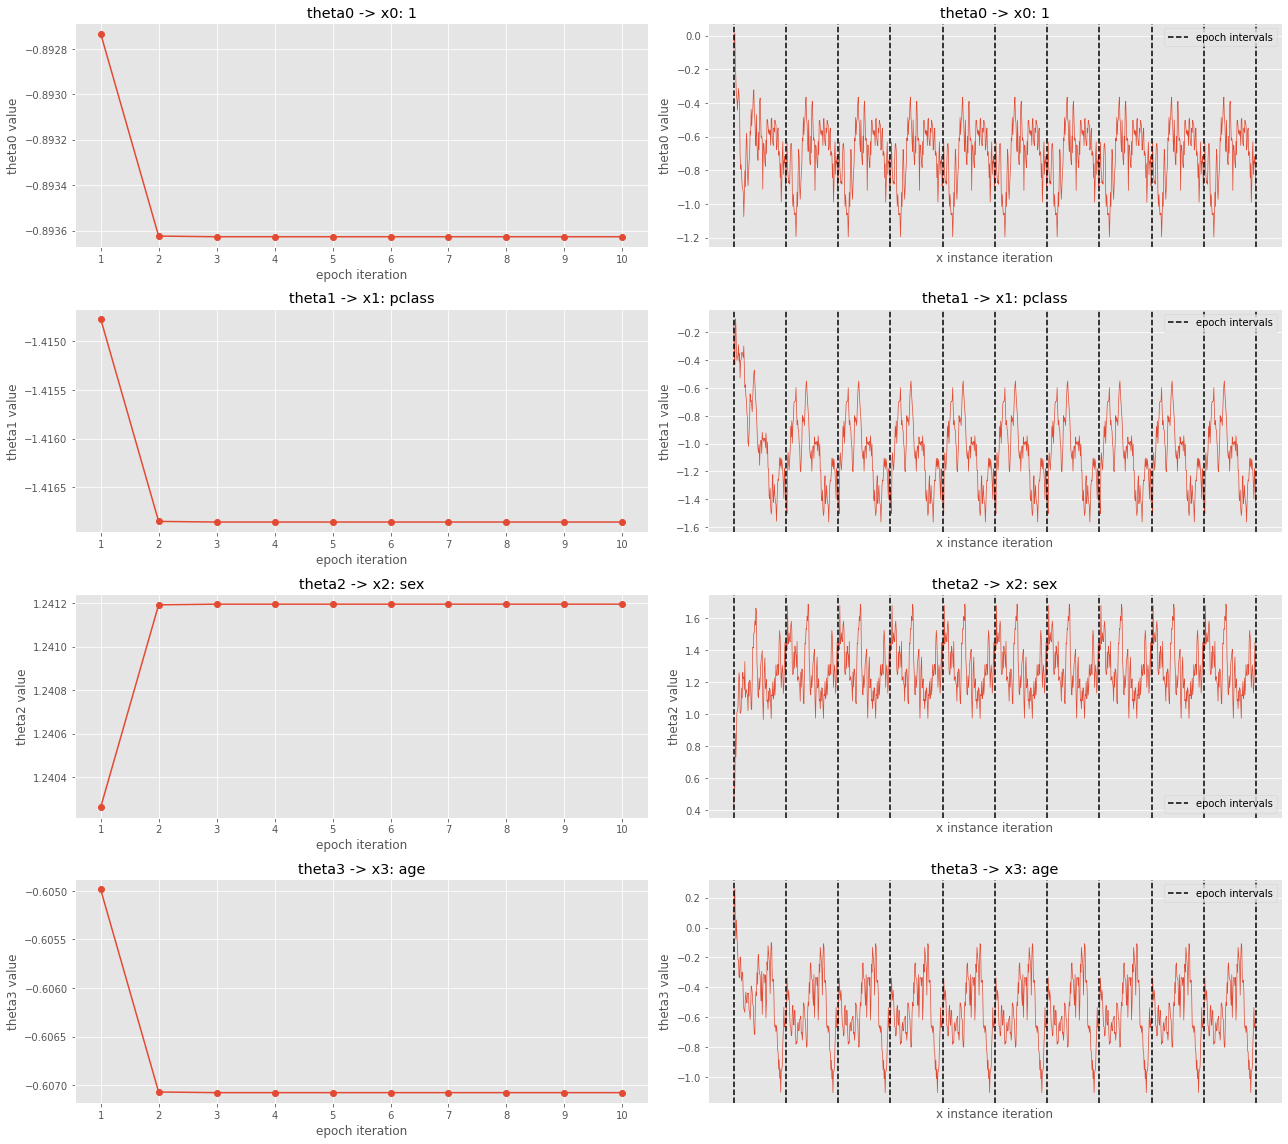

In [11]:
# initial counters
epoch_idx = 0
instance_idx = 0

# define two x-axes, x variable list, and fig, axs for matplotlib
x_axis = [i for i in range(1, 11)]
x_axis_set = [i for i in range(len(theta0_set))]
x_vars = ['1', 'pclass', 'sex', 'age']
fig, axs = plt.subplots(4, 2, figsize=(18, 16))

# two sets of updating theta list: (1) capture thetas for each epoch and (2) capture thetas for every instance
updated_thetas = [theta0, theta1, theta2, theta3]
updated_theta_sets = [theta0_set, theta1_set, theta2_set, theta3_set]

for idx, ax in enumerate(fig.axes):
    # plot epoch updating theta parameters
    if idx % 2 == 0:
        ax.set_title('theta{} -> x{}: {}'.format(epoch_idx, epoch_idx, x_vars[epoch_idx]))
        ax.set_xticks(x_axis)
        ax.set_xlabel('epoch iteration')
        ax.set_ylabel('theta{} value'.format(epoch_idx))
        ax.plot(x_axis, updated_thetas[epoch_idx], ls='-', marker='o')
        epoch_idx += 1
    # plot instance updating theta parameters
    else:
        ax.set_title('theta{} -> x{}: {}'.format(instance_idx, instance_idx, x_vars[instance_idx]))
        ax.set_xticks([])
        ax.set_xlabel('x instance iteration')
        ax.set_ylabel('theta{} value'.format(instance_idx))
        ax.plot(x_axis_set, updated_theta_sets[instance_idx], linewidth=0.7)
        
        # create black dash vertical lines to indicate epoch intervals 
        for epoch_interval in range(0, 1089, 99):
            evline = ax.axvline(epoch_interval, color='black', ls='--')
        ax.legend([evline], ['epoch intervals'], fontsize=10)  
        instance_idx += 1
fig.tight_layout()

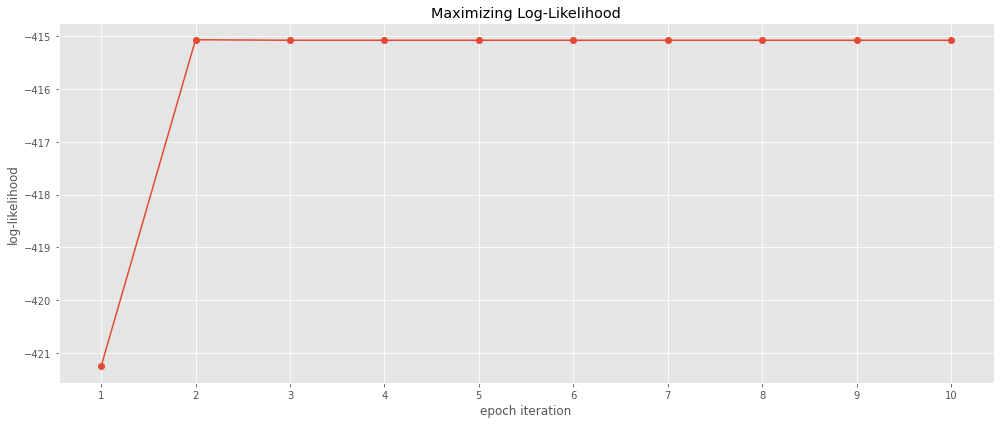

In [12]:
x_axis = [i for i in range(1, 11)]
plt.figure(figsize=(14,6))
plt.title('Maximizing Log-Likelihood')
plt.xticks(x_axis)
plt.xlabel('epoch iteration')
plt.ylabel('log-likelihood')
plt.plot(x_axis, log_likelihood_vals, marker='o')
plt.tight_layout()

In [13]:
# n_epoch = 10 and features standardized
# intercept theta, pclass theta, sex theta, age theta
thetas

array([-0.89362715, -1.41685703,  1.24119596, -0.60707722])

In [32]:
from sklearn.metrics import accuracy_score

def make_predictions(X, thetas):
    X = X.copy()
    pred, pred_proba = [], []
    for x_row in X:
        log_odds = sum(thetas * x_row[:4])
        proba = sigmoid(log_odds)
        pred_proba.append(proba)
        pred.append(1 if proba >= 0.5 else 0)
    return pred, pred_proba

y_train = X_train[:, -1]

y_pred, y_pred_proba = make_predictions(X_train[:, :4], thetas)

accuracy_score(y_train, y_pred)

0.797979797979798

## Logistic Regression: Cross-Entropy Loss & Gradient Descent

In [15]:
%%time

# define number of epoch iterations, learning rate, and initial thetas
n_epoch = 10
learning_rate = 0.1
thetas = [0, 0, 0, 0]

# initialize list to capture updating thetas and minimizing cross_entropy_loss value for each epoch
theta0, theta1, theta2, theta3, ce_loss_vals = [], [], [], [], [] 

# define sigmoid function
def sigmoid(z):
    proba = 1 / (1 + np.exp(-z))
    return proba

for epoch in range(n_epoch):
    # initialize cross entropy loss value
    cross_entropy_loss = 0 # changed
    
    for x in X_train:
        log_odds = sum(thetas * x[:4])
        y_pred_proba = sigmoid(log_odds)
        y_actual = x[-1]
        
        # calculate gradients for each instance
        gradients = (y_pred_proba - y_actual) * x[:4] # changed
        # update thetas using gradient descent
        thetas = thetas - (learning_rate * gradients) # changed
        # sum cross entropy loss value for each epoch iteration
        cross_entropy_loss += y_actual*np.log(y_pred_proba) + (1-y_actual)*np.log(1-y_pred_proba) # changed
    
    # add negative sign
    cross_entropy_loss = -1 * cross_entropy_loss # changed
    ce_loss_vals.append(cross_entropy_loss) # changed
    
    # capture updating thetas at end of each epoch
    theta0.append(thetas[0])
    theta1.append(thetas[1])
    theta2.append(thetas[2])
    theta3.append(thetas[3])

CPU times: user 149 ms, sys: 1.7 ms, total: 151 ms
Wall time: 149 ms


In [16]:
thetas

array([-0.89362715, -1.41685703,  1.24119596, -0.60707722])

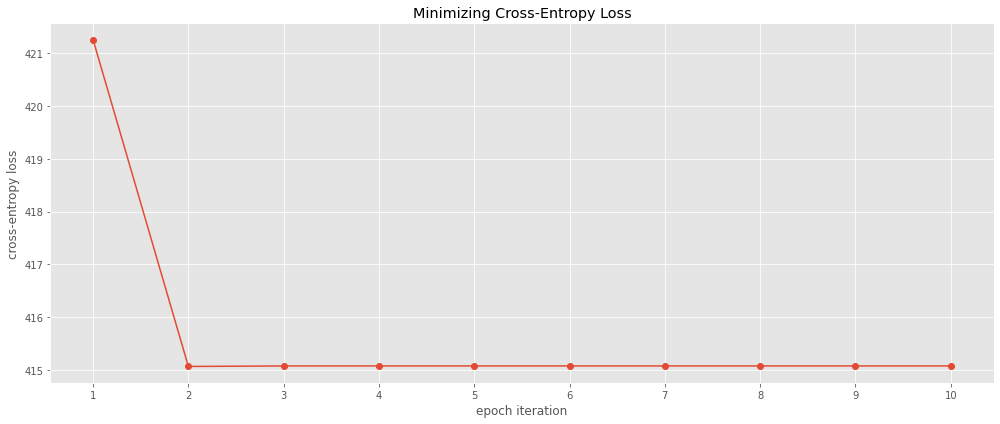

In [17]:
x_axis = [i for i in range(1, 11)]
plt.figure(figsize=(14,6))
plt.title('Minimizing Cross-Entropy Loss')
plt.xticks(x_axis)
plt.xlabel('epoch iteration')
plt.ylabel('cross-entropy loss')
plt.plot(x_axis, ce_loss_vals, marker='o')
plt.tight_layout()

## Plot Sigmoid and Linear Curve using One Feature

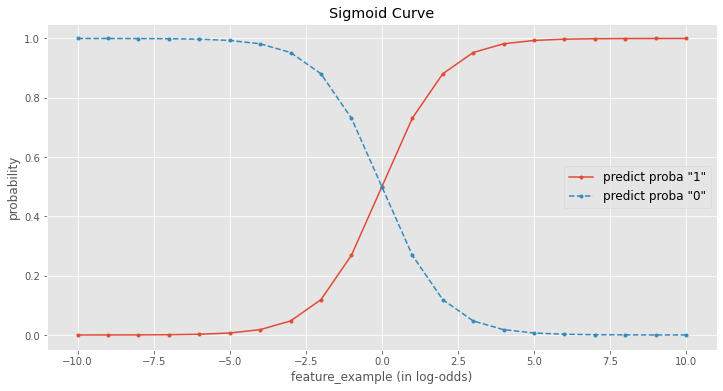

In [18]:
proba1, proba0 = [], []
feature_example = [i for i in range(-10, 11)]
for instance in feature_example:
    p1 = 1/(1 + np.exp(-instance))
    p0 = 1 - p1
    proba1.append(p1)
    proba0.append(p0)
plt.figure(figsize=(12,6))
plt.plot(feature_example, proba1, marker='.', label='predict proba "1"')
plt.plot(feature_example, proba0, marker='.', linestyle='dashed', label='predict proba "0"')
plt.title('Sigmoid Curve')
plt.xlabel('feature_example (in log-odds)')
plt.ylabel('probability')
plt.legend(prop={'size': 12});

## Plot predicted probabilities, odds, and log odds

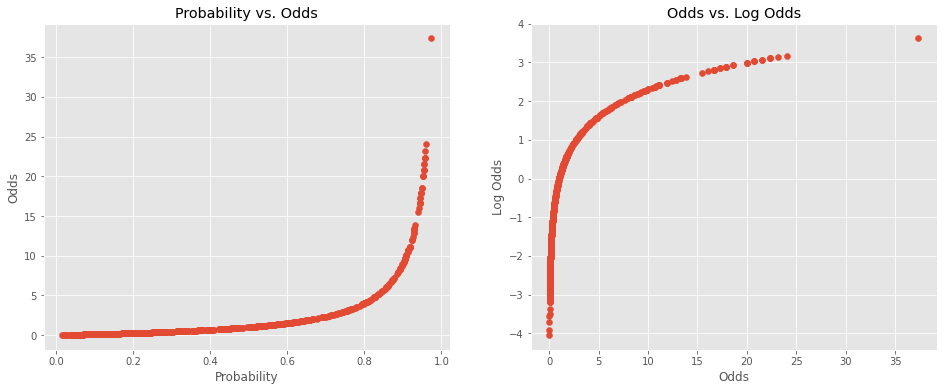

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

logreg = LogisticRegression(random_state=0)
model_pipe = make_pipeline(StandardScaler(), logreg)
X = train[['age','pclass','sex']]
y = train['survived']
model_pipe.fit(X, y)
model_pipe.predict_proba(X)

y_pos_pred_proba = model_pipe.predict_proba(X)[:,1]
y_neg_pred_proba = model_pipe.predict_proba(X)[:,0]
odds = y_pos_pred_proba / y_neg_pred_proba
log_odds = np.log(odds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.set_title('Probability vs. Odds')
ax1.set(xlabel='Probability', ylabel='Odds')
ax1.scatter(y_pos_pred_proba, odds)
ax2.set_title('Odds vs. Log Odds')
ax2.set(xlabel='Odds', ylabel='Log Odds')
ax2.scatter(odds, log_odds);

## ROC Curve and AUC

In [24]:
y_train_s = train['survived']
X_train_s = train[['pclass', 'sex', 'age']]
X_train_s = standardize_numeric_features(X_train_s)
X_train_s.head()

,pclass,sex,age
0,0.826913,-0.737281,-0.550753
1,-1.565228,1.354813,0.632196
2,0.826913,1.354813,-0.255016
3,-1.565228,1.354813,0.410393
4,0.826913,-0.737281,0.410393


In [34]:
# reference: https://mmuratarat.github.io/2019-10-01/how-to-compute-AUC-plot-ROC-by-hand
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

score = y_pred_proba.copy()
y = y_train.copy()

# false positive rate
fpr_ = []

# true positive rate
tpr_ = []

# Iterate thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.05)
# array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

# get number of positive and negative examples in the dataset
p = sum(y)
n = len(y) - p

# iterate through all thresholds and determine fraction of true positives
# and false positives found at this threshold
for thresh in thresholds:
    fp, tp = 0, 0
    for i in range(len(score)):
        if (score[i] >= thresh):
            if y[i] == 1:
                tp += 1
            if y[i] == 0:
                fp += 1
    fpr_.append(fp/n)
    tpr_.append(tp/p)

AUC-ROC: 0.8461636787780015



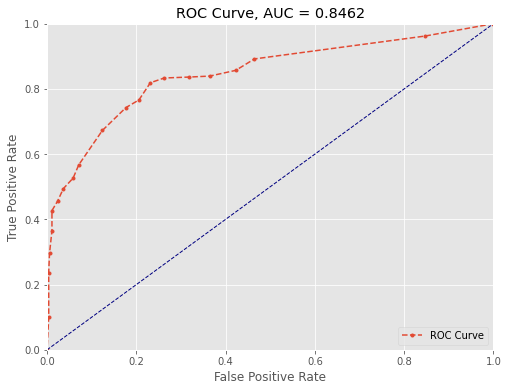

In [36]:
# integrating from right to left, and -1 flips the sign
auc = -1 * np.trapz(tpr_, fpr_)
print(f"AUC-ROC: {auc}")
print()

plt.figure(figsize=(8,6))
plt.plot(fpr_, tpr_, linestyle='--' ,marker='.', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, AUC = %.4f'%auc)
plt.legend(loc="lower right")
plt.show()